## Stance detection

Here is a simple baseline for stance detection using RoBERTa model from [Simple Transformers](https://simpletransformers.ai/) library.

In [102]:
#import libs
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging
import seaborn as sn
import matplotlib.pyplot as plt

In [103]:
#logging 
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

### Training

In [104]:
#read train dataset
train = pd.read_csv('task2_data/train.tsv', sep='\t')

In [105]:
#rename columns to match SimpleTransformers format
column_names = {'Tweet': 'text', 'Stance':'labels'}
train = train.rename(columns = column_names)

#change labels to match SimpleTransformers format
train.loc[train["labels"] == "AGAINST", "labels"] = 0
train.loc[train["labels"] == "FAVOR", "labels"] = 1
train.loc[train["labels"] == "NONE", "labels"] = 2

train

,id,text,Claim,labels,Premise
0,3054935,@realDonaldTrump It's too dangerous to hold th...,school closures,1,1
1,453444,If masks are so important why is the public no...,face masks,0,1
2,211600,But if schools close who is gonna occupy those...,school closures,1,1
3,3049718,@GavinNewsom be the Governor I thought you wer...,stay at home orders,1,1
4,5039679580998,@BBCNews 1. You are reporting 78% uptake on ma...,face masks,1,1
...,...,...,...,...,...
3551,333323,@BremainInSpain #lockdown is a #lifechoice for...,stay at home orders,1,1
3552,910360,The next fucking asshole that tells me there i...,school closures,1,1
3553,769878,Learning should be constant...then . Why not i...,school closures,1,1
3554,648731,Every lockdown has had One Common Clause “Esse...,school closures,0,1


Let's train our model!

In [13]:
%%time
model = ClassificationModel(
    "roberta", "roberta-base", num_labels=3
)
model.train_model(train)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

  0%|          | 0/3556 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_3_2
/home/jovyan/.imgenv-smm4h-gpu-0/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/445 [00:00<?, ?it/s]

/home/user/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


CPU times: user 30.6 s, sys: 8.1 s, total: 38.7 s
Wall time: 47.6 s


(445, 0.9310487619946511)

### Validation

In [112]:
#read validation dataset
val = pd.read_csv('SMM4H_Task2_data/validation.tsv', sep='\t')

#rename columns and values to match the format
val = val.rename(columns=column_names)
val.loc[val["labels"] == "AGAINST", "labels"] = 0
val.loc[val["labels"] == "FAVOR", "labels"] = 1
val.loc[val["labels"] == "NONE", "labels"] = 2

In [20]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(val)
result

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/600 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_3_2


Running Evaluation:   0%|          | 0/75 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.4866502453186264, 'eval_loss': 0.7884440489610036}


In [74]:
#Make predictions on validation tweets
tweets_val = list(val['text'])
stance_predictions = model.predict(tweets_val)[0]
val['predictions'] = stance_predictions

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/610 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

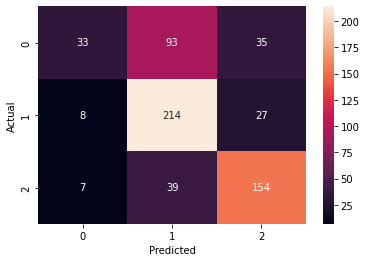

In [95]:
#Let's look at model's predictions distribution
confusion_matrix = pd.crosstab(val['labels'], val['predictions'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

In [101]:
#Mapping back integer labels to words
val.loc[val["predictions"] == 0, "predictions"] = "AGAINST"
val.loc[val["predictions"] == 1, "predictions"] = "FAVOR"
val.loc[val["predictions"] == 2, "predictions"] = "NONE"
#Final submission is need to be in the following format
val = val.drop(columns=['labels', 'Premise']).rename(columns={'predictions':
                                                      'Stance'})
val

,id,text,Claim,Stance
0,7212131785749,Ordered a mask that had a cute chain attached ...,face masks,1
1,2367433035,Who is ready for some #baseball? #BaseballisB...,stay at home orders,2
2,496011,"@Mystere07623203 @va_shiva @Liberty13046 130,0...",face masks,2
3,1490686,When they ask me what I did with my life I wil...,face masks,1
4,1209366,Taylor not putting her album in physical store...,stay at home orders,1
...,...,...,...,...
605,668580,Kenyan Education Minister recently announced t...,school closures,1
606,3583631,@BorisJohnson Never thought I’d say it Boris b...,face masks,1
607,1092611825,If Private schools have earned for many years ...,school closures,2
608,530814,Hearing rumblings of a stay-at-home order for ...,school closures,1
